# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 14.8 MB/s eta 0:00:00
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-lr6z6es1
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-lr6z6es1
  Resolved https://github.com/albumentations-team/albumentations to commit 66212d77a44927a29d6a0e81621d3c27afbd929c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.24
    Uninstalling albucore-0.0.24:
      Successfully uninstalled albucore-0.0.24
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 2.0.8 requires albucore==0.0.24, but you have albucore 0.0.28 which is incompatible

# About Dataset

### Dataset

Here the dataset which we are going to use in this guided project is the subset(200 images and its masks) of the original dataset (Massachusetts Roads Dataset) consists of 1171 aerial images of the state of Massachusetts. Each image is 1500×1500 pixels in size, covering an area of 2.25 square kilometers

### Full Dataset

After compeletion of this project you can try the same pipeline on full dataset

https://www.cs.toronto.edu/~vmnih/data/

```
@phdthesis{MnihThesis,
author = {Volodymyr Mnih},
title = {Machine Learning for Aerial Image Labeling},
school = {University of Toronto},
year = {2013}
}
```

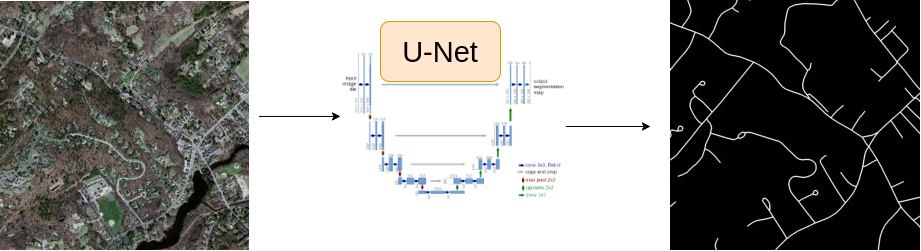

# Download Subset Dataset

In [ ]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

Cloning into 'Road_seg_dataset'...
remote: Enumerating objects: 411, done.
remote: Total 411 (delta 0), reused 0 (delta 0), pack-reused 411 (from 1)
Receiving objects: 100% (411/411), 851.74 MiB | 16.13 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (401/401), done.


# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Road_seg_dataset')

In [ ]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [ ]:
CSV_Path = '/content/Road_seg_dataset/train.csv'
data_dir = '/content/Road_seg_dataset/'
device = 'cuda'

epochs = 20
batch_size = 16
learning_rate = 0.0001
img_size = 512

encoder='timm-efficientnet-b0'
weights = 'imagenet'

In [ ]:
df = pd.read_csv(CSV_Path)
df.head()

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png


In [ ]:
from re import I
idk = 2

row = df.iloc[idk]
image_path =data_dir + row['images']
mask_path = data_dir + row['masks']

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE) /255.0

mask.shape

(1500, 1500)

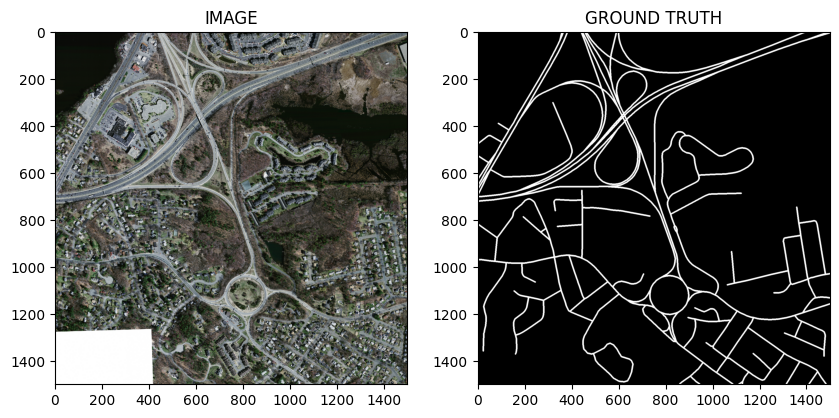

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
len(train_df), len(val_df)

(159, 40)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

def get_train_augs():

   return A.Compose([
      A.Resize(img_size,img_size),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ])

def get_valid_augs():
  return A.Compose([
      A.Resize(img_size,img_size)
  ])

# Task 4 : Create Custom Dataset

In [ ]:
from torch.utils.data import Dataset

class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    image_path = data_dir + row['images']
    mask_path = data_dir + row['masks']

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
    mask = np.expand_dims(mask, axis=-1)

    if self.augmentations:
      aug = self.augmentations(image=image, mask=mask)
      image = aug['image']
      mask = aug['mask']

    image = np.transpose(image, (2,0,1)).astype(np.float32) # changing (H,W,C) -> (C,H,W)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask


In [ ]:
traindataset = SegmentationDataset(train_df, get_train_augs())
valdataset = SegmentationDataset(val_df, get_valid_augs())

In [ ]:
print(f"Total Train Images : {len(traindataset)}")
print(f"Total Validation Images : {len(valdataset)}")

Total Train Images : 159
Total Validation Images : 40


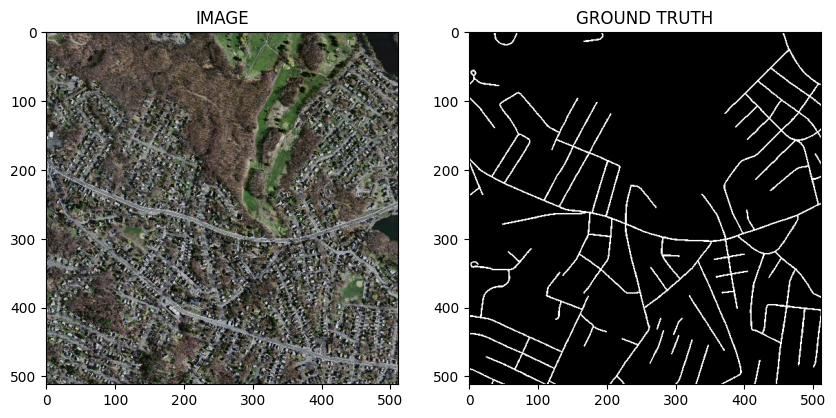

In [ ]:
idx =20
image, mask = traindataset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

trainloader = DataLoader(traindataset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(valdataset, batch_size=batch_size)

In [ ]:
print(f"Total Train Batches : {len(trainloader)}")
print(f"Total Validation Batches : {len(valloader)}")

Total Train Batches : 10
Total Validation Batches : 3


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

from torch import nn

In [ ]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name=encoder,
        encoder_weights=weights,
        in_channels=3,
        classes=1,
        activation=None
    )

  def forward(self, images, masks=None):

    logits = self.arc(images)
    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits, masks) + nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1
    return logits

In [ ]:
model = SegmentationModel()
model = model.to(device)

# Task 7 : Create Train and Validation Function

In [ ]:
def train_fn(data_loader, model, optimizer):
  model.train()

  total_loss = 0

  for images, masks in tqdm(data_loader):
    images = images.to(device)
    masks = masks.to(device)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss/len(data_loader)

In [ ]:
def val_fn(data_loader, model):
  model.train()

  total_loss = 0
  with torch.no_grad():
    for images, masks in tqdm(data_loader):
      images = images.to(device)
      masks = masks.to(device)
      logits, loss = model(images, masks)
      total_loss += loss.item()

    return total_loss/len(data_loader)

# Task 8 : Train Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epochs = 30
best_loss = np.inf
early_stop_counter = 0
patience = 5
min_delta = 0.001 # Minimum change to be considered an improvement

for i in range(epochs):
  train_loss = train_fn(trainloader, model, optimizer)
  val_loss = val_fn(valloader, model)

  # Early stopping logic
  if val_loss < best_loss - min_delta:
    best_loss = val_loss
    torch.save(model.state_dict(), 'best_model.pt')
    print("Model saved (validation loss improved).")
    early_stop_counter = 0
  else:
    early_stop_counter += 1
    print(f"Validation loss did not improve. Early stop counter: {early_stop_counter}")

  if early_stop_counter >= patience:
    print("Early stopping triggered.")
    break

  print(f"Epoch : {i+1} , Train loss :{train_loss} , val loss: {val_loss}")

100%|██████████| 3/3 [00:03<00:00,  1.23s/it]


Model saved (validation loss improved).
Epoch : 1 , Train loss :1.373810601234436 , val loss: 1.3626481691996257


100%|██████████| 3/3 [00:03<00:00,  1.30s/it]


Validation loss did not improve. Early stop counter: 1
Epoch : 2 , Train loss :1.3511462330818176 , val loss: 1.3730956315994263


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


Model saved (validation loss improved).
Epoch : 3 , Train loss :1.3373629927635193 , val loss: 1.3358653783798218


100%|██████████| 3/3 [00:04<00:00,  1.37s/it]


Model saved (validation loss improved).
Epoch : 4 , Train loss :1.3210750937461853 , val loss: 1.32375701268514


100%|██████████| 3/3 [00:03<00:00,  1.25s/it]


Model saved (validation loss improved).
Epoch : 5 , Train loss :1.3136377215385437 , val loss: 1.3122497002283733


100%|██████████| 3/3 [00:03<00:00,  1.23s/it]


Model saved (validation loss improved).
Epoch : 6 , Train loss :1.3001724123954772 , val loss: 1.3015232880910237


100%|██████████| 3/3 [00:03<00:00,  1.24s/it]


Model saved (validation loss improved).
Epoch : 7 , Train loss :1.289269495010376 , val loss: 1.2911606629689534


100%|██████████| 3/3 [00:03<00:00,  1.24s/it]


Model saved (validation loss improved).
Epoch : 8 , Train loss :1.2802496671676635 , val loss: 1.281558911005656


100%|██████████| 3/3 [00:03<00:00,  1.28s/it]


Model saved (validation loss improved).
Epoch : 9 , Train loss :1.267045295238495 , val loss: 1.268083135286967


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


Model saved (validation loss improved).
Epoch : 10 , Train loss :1.259353256225586 , val loss: 1.2597488562266033


100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


Model saved (validation loss improved).
Epoch : 11 , Train loss :1.2453777551651002 , val loss: 1.2453874349594116


100%|██████████| 3/3 [00:03<00:00,  1.25s/it]


Model saved (validation loss improved).
Epoch : 12 , Train loss :1.2318876266479493 , val loss: 1.2328325112660725


100%|██████████| 3/3 [00:03<00:00,  1.24s/it]


Model saved (validation loss improved).
Epoch : 13 , Train loss :1.2195610284805298 , val loss: 1.222133755683899


100%|██████████| 3/3 [00:03<00:00,  1.25s/it]


Model saved (validation loss improved).
Epoch : 14 , Train loss :1.2047447919845582 , val loss: 1.209161639213562


100%|██████████| 3/3 [00:03<00:00,  1.25s/it]


Model saved (validation loss improved).
Epoch : 15 , Train loss :1.1906663656234742 , val loss: 1.1961493094762166


100%|██████████| 3/3 [00:03<00:00,  1.30s/it]


Model saved (validation loss improved).
Epoch : 16 , Train loss :1.1776927351951598 , val loss: 1.182812492052714


100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


Model saved (validation loss improved).
Epoch : 17 , Train loss :1.1615702509880066 , val loss: 1.1680186589558919


100%|██████████| 3/3 [00:04<00:00,  1.37s/it]


Model saved (validation loss improved).
Epoch : 18 , Train loss :1.1483621716499328 , val loss: 1.1643613179524739


100%|██████████| 3/3 [00:03<00:00,  1.24s/it]


Model saved (validation loss improved).
Epoch : 19 , Train loss :1.1371625185012817 , val loss: 1.1412619749704997


100%|██████████| 3/3 [00:03<00:00,  1.23s/it]


Model saved (validation loss improved).
Epoch : 20 , Train loss :1.1251553654670716 , val loss: 1.1320234139760335


100%|██████████| 3/3 [00:03<00:00,  1.24s/it]


Model saved (validation loss improved).
Epoch : 21 , Train loss :1.1090367317199707 , val loss: 1.1163535912831624


100%|██████████| 3/3 [00:03<00:00,  1.25s/it]


Model saved (validation loss improved).
Epoch : 22 , Train loss :1.0982542037963867 , val loss: 1.106539249420166


100%|██████████| 3/3 [00:03<00:00,  1.24s/it]


Model saved (validation loss improved).
Epoch : 23 , Train loss :1.0845923662185668 , val loss: 1.0949459473292034


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


Model saved (validation loss improved).
Epoch : 24 , Train loss :1.0711625814437866 , val loss: 1.0831265449523926


100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


Model saved (validation loss improved).
Epoch : 25 , Train loss :1.0649474143981934 , val loss: 1.0693461100260417


100%|██████████| 3/3 [00:03<00:00,  1.28s/it]


Model saved (validation loss improved).
Epoch : 26 , Train loss :1.0449358224868774 , val loss: 1.0587763786315918


 90%|█████████ | 9/10 [00:19<00:02,  2.20s/it]

# Task 9 : Inference

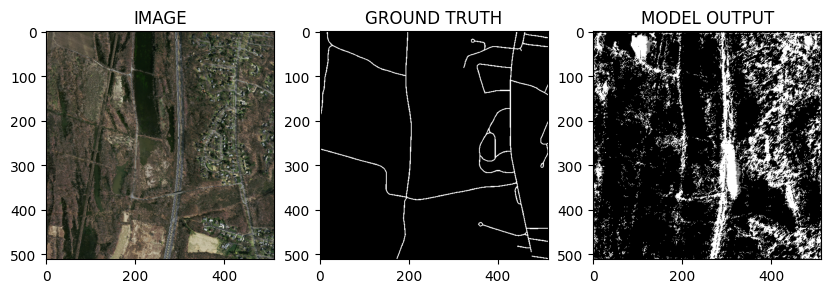

In [ ]:
 idx =1

 model.load_state_dict(torch.load('/content/best_model.pt'))
 image, mask = valdataset[idx]

 logits_mask = model(image.to(device).unsqueeze(0))
 logits_mask = torch.sigmoid(logits_mask)
 predicted_mask = (logits_mask > 0.5) * 1.0
 predicted_mask = predicted_mask.detach().cpu().squeeze(0)
 helper.show_image(image, mask , predicted_mask)